In [42]:
import glob
import time
import cv2
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from skimage.feature import hog
import pickle
from functions import *
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip

In [43]:
import os
os.listdir("test_images/")

['.DS_Store',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg',
 'test4.jpg',
 'test5.jpg',
 'test6.jpg']

In [44]:
img1 = mpimg.imread('test_images/test1.jpg')
img2 = mpimg.imread('test_images/test2.jpg')
img3 = mpimg.imread('test_images/test3.jpg')
img4 = mpimg.imread('test_images/test4.jpg')
img5 = mpimg.imread('test_images/test5.jpg')
img6 = mpimg.imread('test_images/test6.jpg')

In [45]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):  
    '''
    The function extracts features from a single image window
    very similar to extract_features() just for a single image 
    rather than list of images
    '''
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))      
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

def search_windows(img, windows, clf, scaler, color_space='RGB', 
                   spatial_size=(32, 32), hist_bins=32, 
                   hist_range=(0, 256), orient=9, 
                   pix_per_cell=8, cell_per_block=2, 
                   hog_channel=0, spatial_feat=True, 
                   hist_feat=True, hog_feat=True):
    '''
    The function returns the list of windows to be searched
    '''
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                                       spatial_size=spatial_size, hist_bins=hist_bins, 
                                       orient=orient, pix_per_cell=pix_per_cell, 
                                       cell_per_block=cell_per_block, 
                                       hog_channel=hog_channel, spatial_feat=spatial_feat,
                                       hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def add_heat(heatmap, bboxlist):
    # Iterate through list of bboxes
    for box in bboxlist:
        # Add += 1 for all pixels inside each bbox
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        #print(nonzero)
        # (array([456, 456, 456, ..., 519, 519, 519]), array([546, 547, 548, ..., 583, 584, 585]))
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        #reclist, weights = cv2.groupRectangles(np.array(rect).tolist(), groupThreshold = 1, eps = 0.2)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def draw_boxes(img, bboxes, color=(0, 0, 255), thickness=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thickness)
    # Return the image copy with boxes drawn
    return imcopy

In [46]:
def pipeline(image, svc, X_scaler, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2,
                     hog_channel = 0, spatial_size=(32, 32), hist_bins=32,
                     spatial_feat=True, hist_feat=True, hog_feat=True, displayType='final'):
    # Uncomment the following line if you extracted training
    # data from .png images (scaled 0 to 1 by mpimg) and the
    # image you are searching is a .jpg (scaled 0 to 255)
    #global all_bboxes
    draw_image = image.copy()
    image = image.copy().astype(np.float32)/255


    y_start_stop = [380, 650] # Min and max in y to search in slide_window()

    S_wind = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(48, 48), xy_overlap=(0.5, 0.5))
    M_wind = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(64, 64), xy_overlap=(0.5, 0.5))
    L_wind = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(128, 128), xy_overlap=(0.5, 0.5))
    XL_wind = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop,
                        xy_window=(256, 256), xy_overlap=(0.5, 0.5))

    windows = S_wind + M_wind + L_wind + XL_wind
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space,
                            spatial_size=spatial_size, hist_bins=hist_bins,
                            orient=orient, pix_per_cell=pix_per_cell,
                            cell_per_block=cell_per_block,
                            hog_channel=hog_channel, spatial_feat=spatial_feat,
                            hist_feat=hist_feat, hog_feat=hog_feat)
    
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    all_bboxes = []
    if hot_windows:
        all_bboxes.insert(0, hot_windows)
        if len(all_bboxes) > 8:
            all_bboxes.pop()
        for idx, bboxlist in enumerate(all_bboxes):
            heatmap = add_heat(heatmap, bboxlist)
        heatmap = apply_threshold(heatmap, 3)
    #heat = rgb2gray(heatmap)
    labels = None
    draw_img = None
    blobapplied = False
    if heatmap.any():
        if blobapplied:
            blobs = blob_doh(heatmap)
            blobs = blobs.astype(np.uint32)
            print(blobs)
            centroids = np.zeros(heatmap.shape, dtype=np.bool)
            centroids[blobs[:, 0], blobs[:, 1]] = True
            markers = ndi.label(centroids)[0]
            labels = watershed(-heatmap, markers, mask=heatmap)
            labels = label(labels)
        else:
            labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
    else:
        draw_img = image
        
    return draw_img

#     window_img = draw_labeled_bboxes(draw_image, hot_windows, color=(0, 255, 0), thickness=5)
#     return window_img

In [47]:
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [48]:
svc = pickle.load(open("pickel_data/svc.pkl", "rb") )
X_scaler = pickle.load(open("pickel_data/xscaler.pkl", "rb"))

In [49]:
def process_image(image):
    return pipeline(image, svc, X_scaler, color_space=color_space,
                    spatial_size=spatial_size, hist_bins=hist_bins,
                    orient=orient, pix_per_cell=pix_per_cell,
                    cell_per_block=cell_per_block,
                    hog_channel=hog_channel, spatial_feat=spatial_feat,
                    hist_feat=hist_feat, hog_feat=hog_feat, displayType=type)

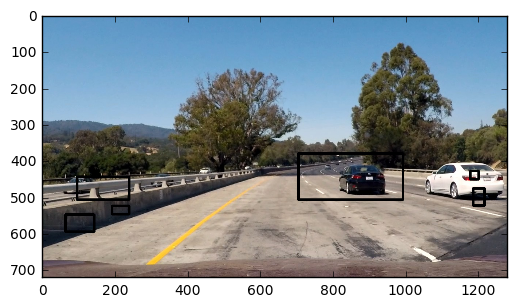

In [55]:
plt.imshow(process_image(img1))
plt.show()

In [ ]:
project_output = 'project_video_extract.mp4'
clip1 = VideoFileClip("project_video.mp4")
project_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
project_clip.write_videofile(project_output, audio=False)